#### Library Import

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from itertools import combinations
from scipy.signal import welch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from mne import Epochs, pick_types, events_from_annotations, set_log_level
from mne.channels import make_standard_montage
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import (
    index_below_threshold,
    display_descriptive_statistics,
    evaluate_and_visualize,
    extract_motor_imagery_data,
    split_eeg_data,
    classify_individual_subjects,
    visualize_csp_components,
    get_BCI_competition_data,
    evaluate_classification_metrics
)

from models import create_ATCNet, create_spectral_transformer_model

# Log configuration
set_log_level('CRITICAL')

# Seaborn configuration
sns.set(style="ticks")

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration to display plots in the notebook
%matplotlib inline

c:\Users\yasse\anaconda3\envs\NN\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Load data

**Data Extraction for a Given Subject:**
We start by loading the data for Subject No. 1. The sessions used are 6, 10, and 14, which contain motor imagery recordings for hands and feet.

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPU:", gpus)
    # Set TensorFlow to allocate memory dynamically on the GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Define parameters
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3) # motor imagery: hands vs feet
runs = [6, 10, 14]  # Runs where hands and feet motor imagery are recorded
subject = 1

# Load EEG data and concatenate sessions
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    
# Standardize channels
eegbci.standardize(raw)
    
# Apply standard montage (10-10 system)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply bandpass filter
# Note: For NeuroImaging purposes, the frequency range is between 7 Hz to 30 Hz
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

# Get events and picks
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (training between 1 and 2 seconds after the event)
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,)

epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2
raw

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

#### Data Analysis:

We start by visualizing the montage of the international 10-10 system used for capturing EEG signals.

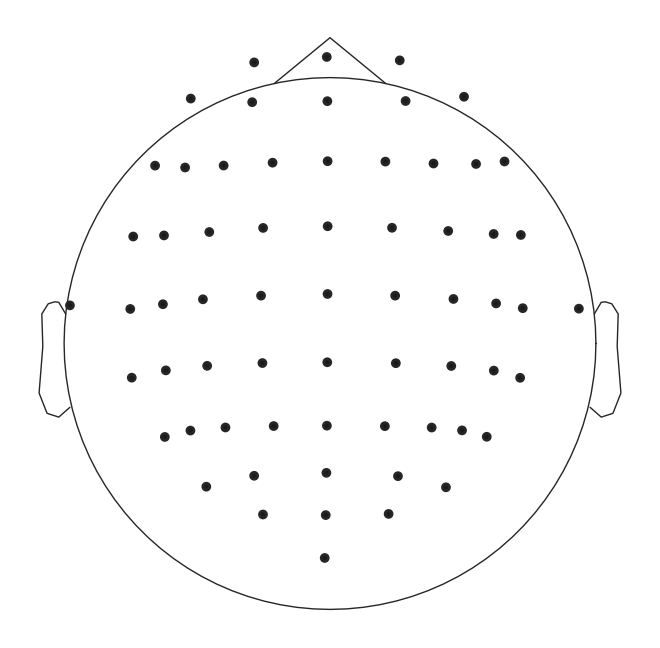

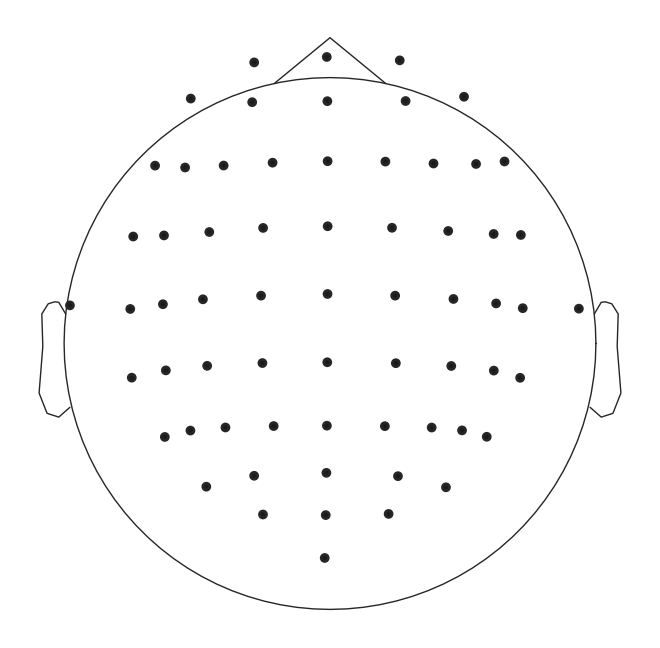

In [4]:
raw.plot_sensors()

Let's examine a brief segment of the EEG signal for the FP1 channel. The sample has been trimmed to a duration of only 6 seconds to facilitate a clearer visualization.

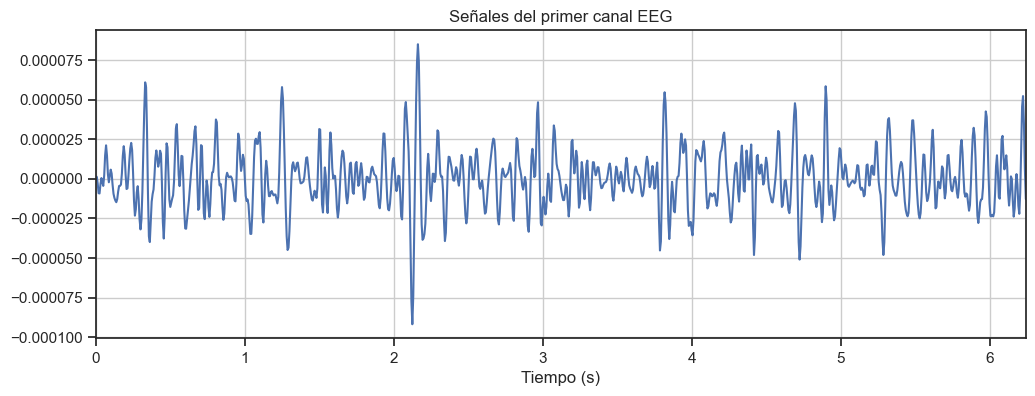

In [5]:
idx_channel = 0
n_samples = 1000
fs = 160
X = raw._data[idx_channel][:n_samples]
t = np.arange(X.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(t, X)
plt.xlabel('Tiempo (s)')
plt.grid()
plt.title('Señales del primer canal EEG')
plt.xlim([t[0], t[-1]])
plt.show()

The ensemble of signals is then visualized using **Power Signal Density** (PSD) to obtain a representation of the filtering within the 7 Hz to 30 Hz range. It is within this frequency range that the motor impulses of the human body are predominantly present.

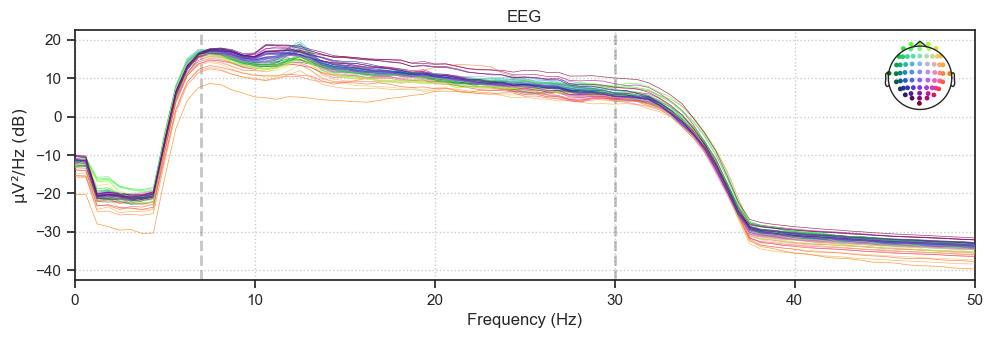

In [6]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")

The impact of applying the bandpass filter to the signal can be observed in the following spectrogram.

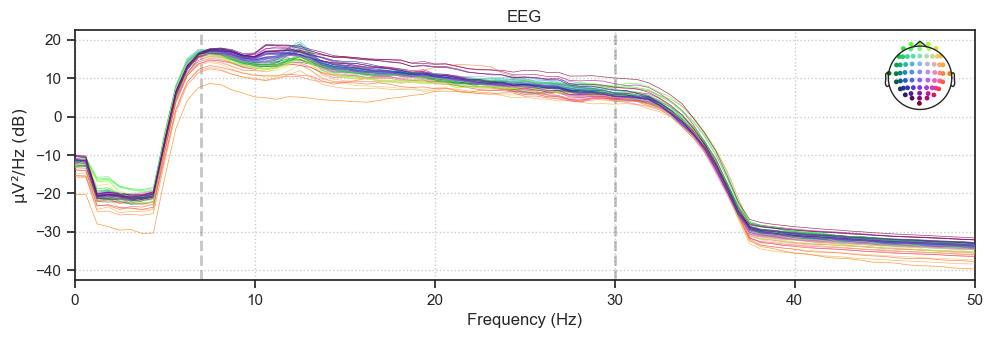

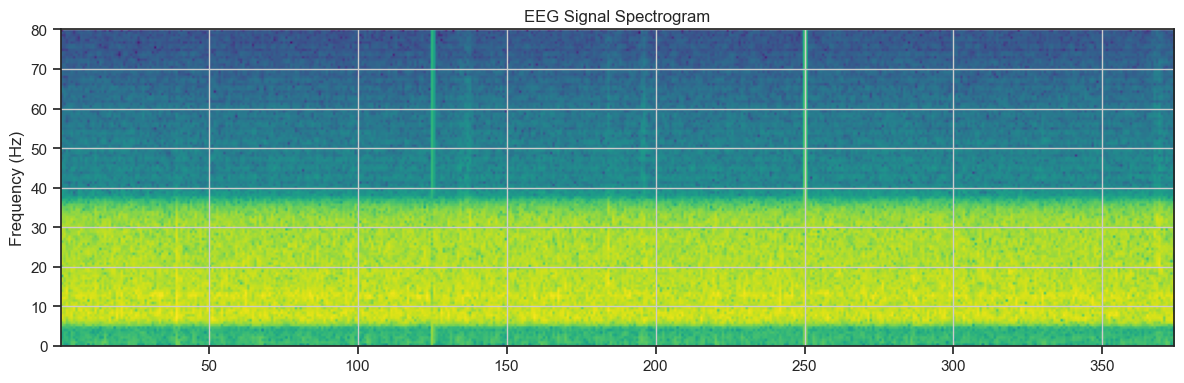

In [7]:
data_original = raw.copy().get_data()[0]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the spectrogram of the original unfiltered signal
ax1.specgram(data_original, Fs=raw.info['sfreq'], cmap='viridis')
ax1.set_title('EEG Signal Spectrogram')
ax1.set_ylabel('Frequency (Hz)')
ax1.grid()

# Adjust the figure layout and display the visualization
plt.tight_layout()
plt.show()

A **Common Spatial Patterns** (CSP) is applied to extract the four main components of the data. This allows us to visualize the four components and the areas of higher activity in the assigned task for Subject No. 1.

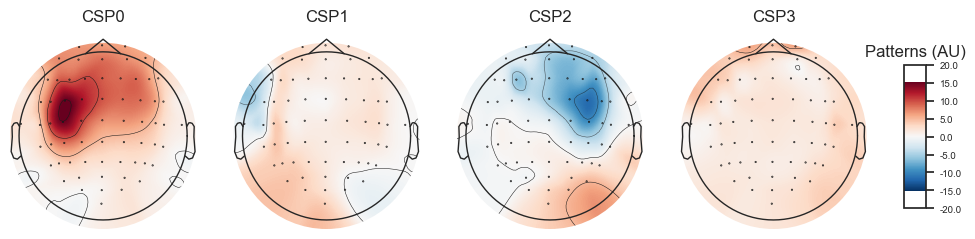

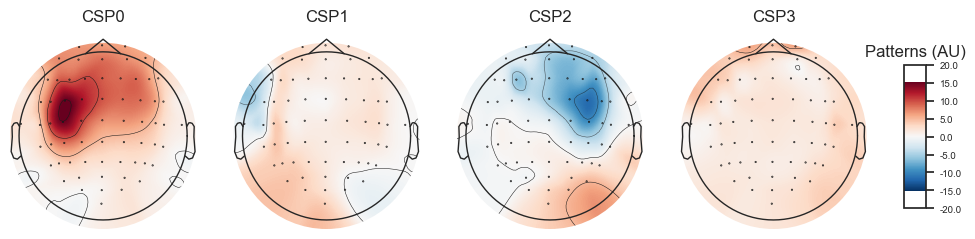

In [8]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

The obtained components from the CSP can be visualized with greater precision.

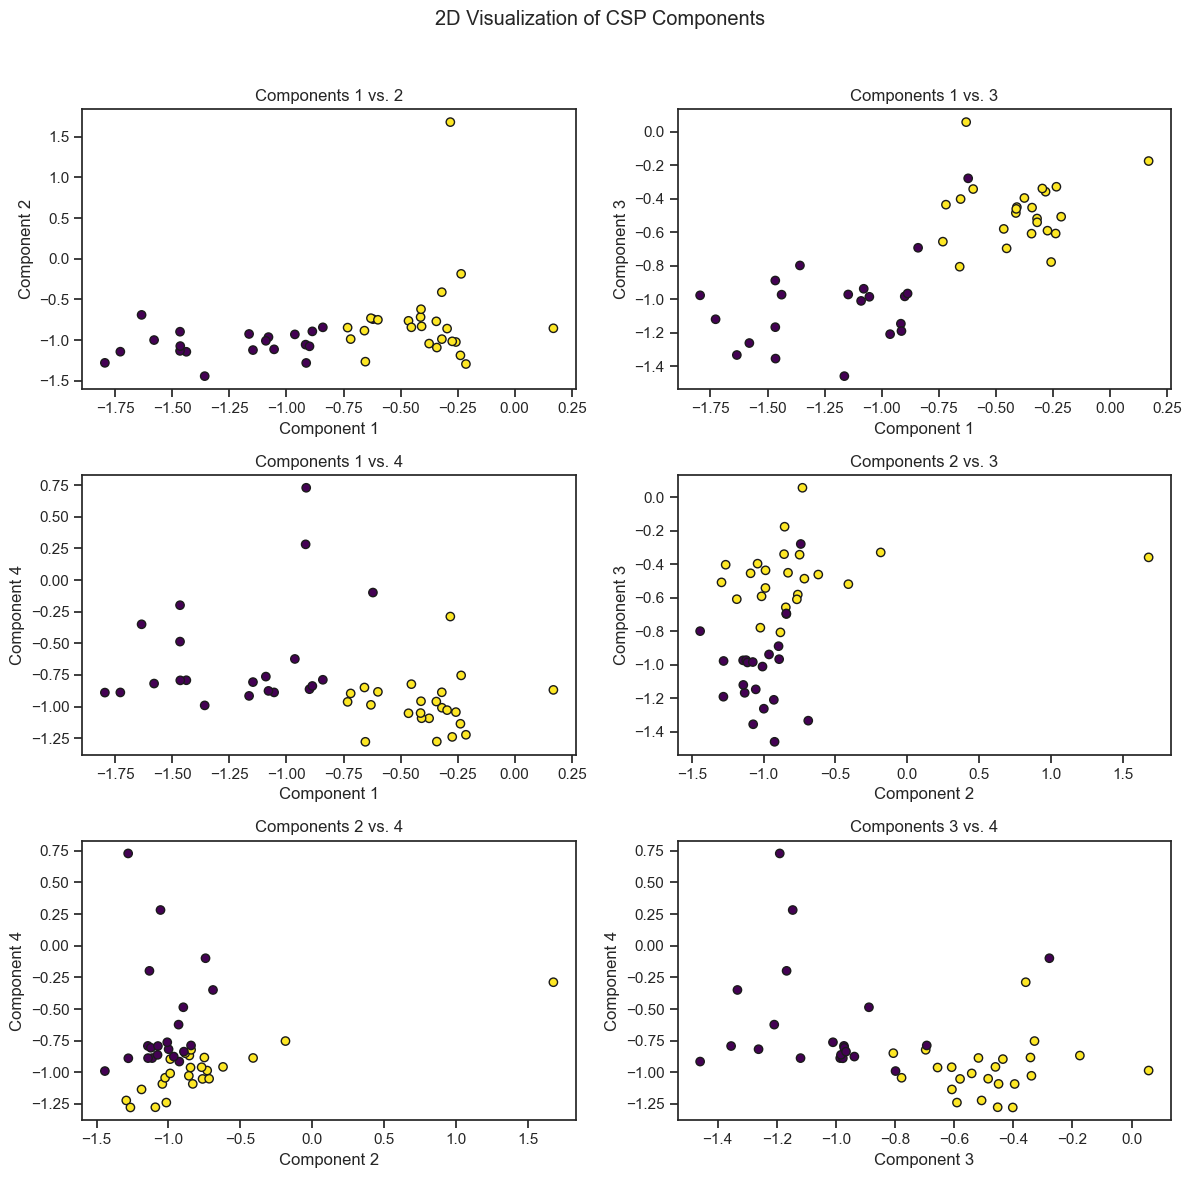

In [11]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Plot CSP patterns estimated on full data for visualization
X_train_reshaped_csp = csp.fit_transform(epochs_data, labels)

# Get all possible combinations of two components
combinations_2d = list(combinations(range(X_train_reshaped_csp.shape[1]), 2))

# Create subplots
fig, axes = plt.subplots(nrows=len(combinations_2d)//2, ncols=2, figsize=(12, 12))
fig.suptitle('2D Visualization of CSP Components')

# Visualize each combination in a 2D plot
for i, (component1, component2) in enumerate(combinations_2d):
    ax = axes[i // 2, i % 2]
    ax.scatter(X_train_reshaped_csp[:, component1], X_train_reshaped_csp[:, component2], c=labels, cmap='viridis', marker='o', edgecolors='k')
    ax.set_xlabel(f'Component {component1 + 1}')
    ax.set_ylabel(f'Component {component2 + 1}')
    ax.set_title(f'Components {component1 + 1} vs. {component2 + 1}')

# Adjust the layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Modeling Phase

For the modeling phase, we will experiment with various methods to perform a general classification of all signals from all subjects. In total, we have 109 subjects with approximately 45 samples each.

In [9]:
# Load data for all subjects
# Non-standardized data
X_train_reshaped, y_train, X_test_reshaped, y_test = split_eeg_data(standardize=False)
# Standardized data
X_train_reshaped_std, _, X_test_reshaped_std, _ = split_eeg_data(standardize=True)


  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 109/109 [02:09<00:00,  1.19s/it]


In [10]:
# Print shapes for verification
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)
print("Shape of X_train_reshaped_std:", X_train_reshaped_std.shape)
print("Shape of X_test_reshaped_std:", X_test_reshaped_std.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train_reshaped: (4272, 64, 161)
Shape of X_test_reshaped: (475, 64, 161)
Shape of X_train_reshaped_std: (4272, 64, 161)
Shape of X_test_reshaped_std: (475, 64, 161)
Shape of y_train: (4272,)
Shape of y_test: (475,)


#### **Machine Learning:** Common Spatial Pattern - Linear Discriminant Analysis (CSP-LDA)

We first experiment with the classical techniques commonly used in the literature.

#### **Deep Learning:** Convolutional Neural Networks (CNNs) y Neural Networks (NNs)

##### Experiment No. 1: CNN

In [18]:
# Build the CNN model
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 161, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])


In [12]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPU:", gpus)
    # Set TensorFlow to allocate memory dynamically on the GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Without standardization:

In [14]:
X_train_reshaped = np.expand_dims(X_train_reshaped, axis=-1)
X_test_reshaped = np.expand_dims(X_test_reshaped, axis=-1)

In [19]:
# Train the model and store the history
history = model.fit(X_train_reshaped, y_train, epochs=30, validation_data=(X_test_reshaped, y_test))
evaluate_and_visualize(model, history, X_test_reshaped, y_test)

Epoch 1/30
134/134 [==============================] - 3s 15ms/step - loss: 0.6933 - accuracy: 0.4892 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 2/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 3/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 4/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 5/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 6/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 7/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842

0.4842105263157895

With standardization:

In [21]:
X_train_reshaped_std = np.expand_dims(X_train_reshaped_std, axis=-1)
X_test_reshaped_std = np.expand_dims(X_test_reshaped_std, axis=-1)

In [22]:
# Train the model and store the history
history = model.fit(X_train_reshaped_std, y_train, epochs=30, validation_data=(X_test_reshaped_std, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_std, y_test)

Epoch 1/30
134/134 [==============================] - 2s 13ms/step - loss: 0.7076 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 2/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 3/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 4/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 5/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6935 - val_accuracy: 0.4842
Epoch 6/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6924 - accuracy: 0.5016 - val_loss: 0.6939 - val_accuracy: 0.4737
Epoch 7/30
134/134 [==============================] - 2s 12ms/step - loss: 0.6895 - accuracy: 0.5199 - val_loss: 0.6992 - val_accuracy: 0.4779

0.5621052631578948

### Results Analysis

As we can observe, the models used in the modeling phase do not achieve decent results. Overall, all employed models have an accuracy around $60\%$, only $10\%$ above the $50\%$ that would be obtained by random guessing. In the following visualization, we present the result of applying CSP to all subjects simultaneously.       

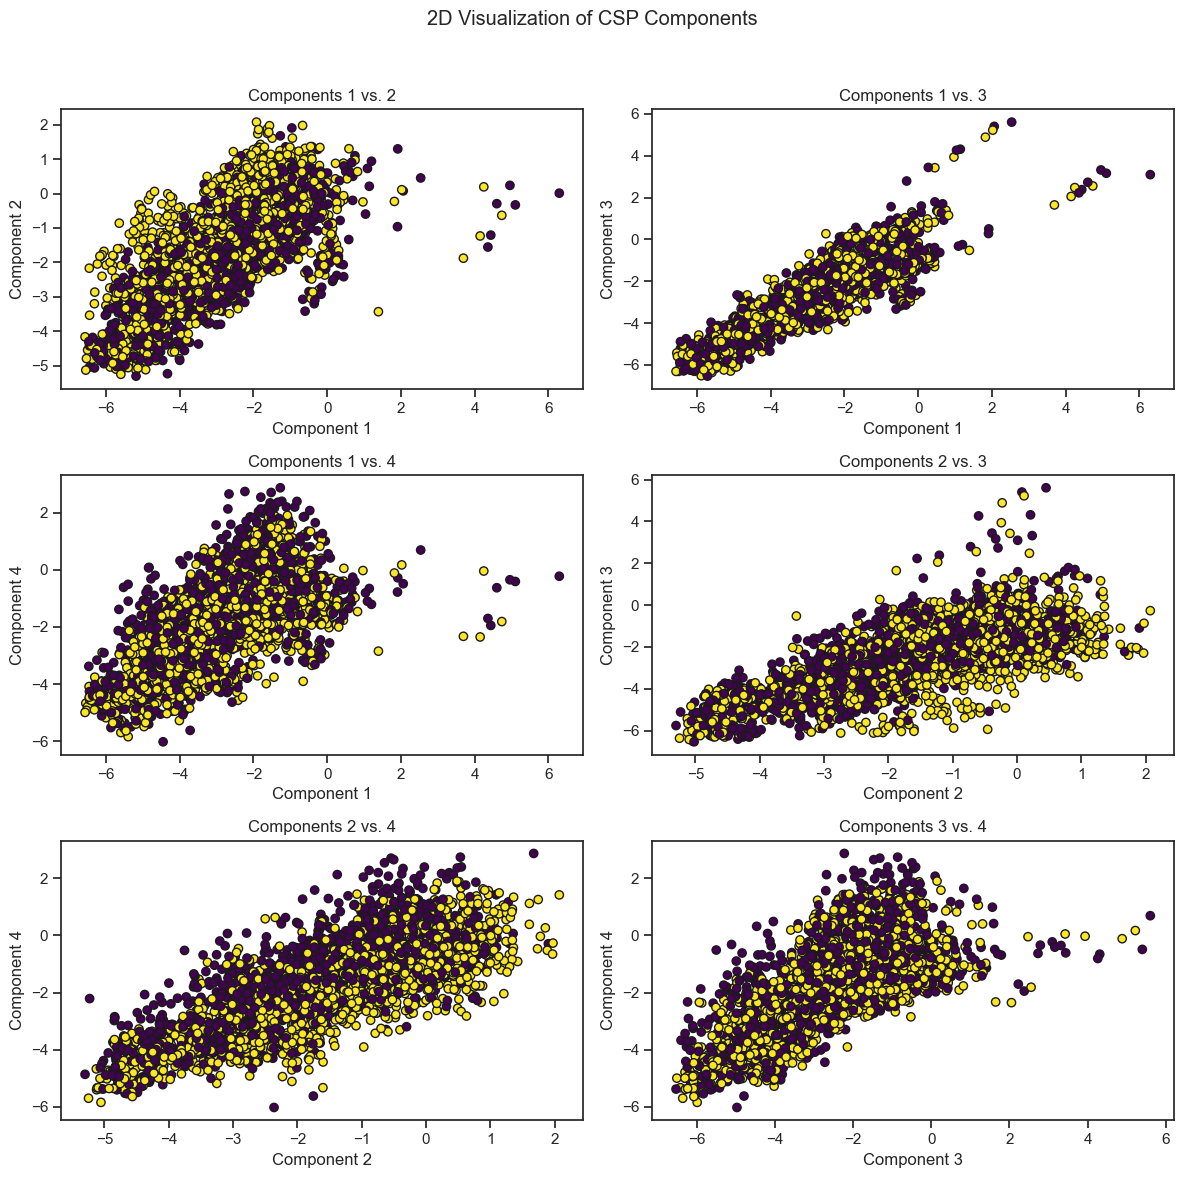

In [ ]:
visualize_csp_components(X_train_reshaped, y_train, num_csp_components=4)

As observed in the previous figure, the data is practically inseparable. This makes it challenging, if not impossible, for the methods used for signal classification. However, when we employ the techniques previously used individually for each subject, we obtain good results for certain specific patients. This type of technique is referred to as [Subject-dependent EEG classification](https://dl.acm.org/doi/10.1145/3388142.3388167).

100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


# Subjects processed: 106 / 110  (96.36%)
Mean: 0.6377358490566037
Variance: 0.06876468494126024
Minimum: 0.0
Maximum: 1.0
Median: 0.6
Mode: 0.8


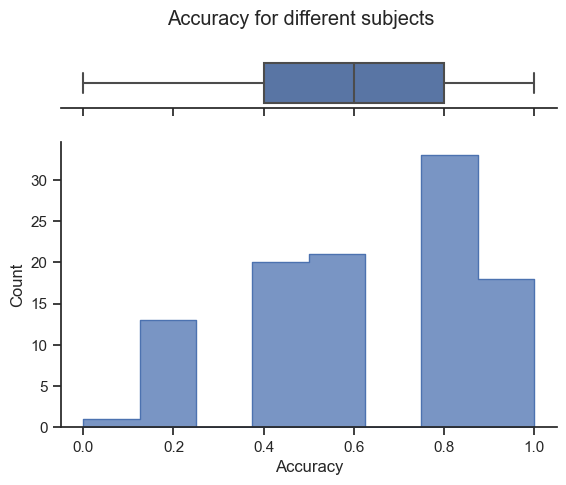

In [ ]:
# Prediction with CSP-LDA
acc_results_csplda = classify_individual_subjects(use_lda=True)
idx_csplda = index_below_threshold(acc_results_csplda, threshold=0.6)
display_descriptive_statistics(acc_results_csplda)

  4%|▎         | 4/109 [00:23<10:24,  5.95s/it]

  5%|▍         | 5/109 [00:29<10:14,  5.91s/it]

100%|██████████| 109/109 [11:03<00:00,  6.08s/it]


# Subjects processed: 106 / 110  (96.36%)
Mean: 0.6433962264150942
Variance: 0.0724563901744393
Minimum: 0.0
Maximum: 1.0
Median: 0.6
Mode: 0.8


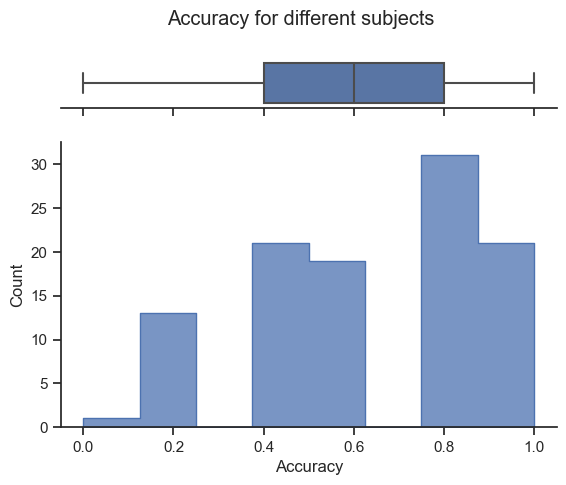

In [ ]:
# Prediction with CSP-NN
acc_results_nn = classify_individual_subjects(use_lda=False)
idx_nn = index_below_threshold(acc_results_nn, threshold=0.6)
display_descriptive_statistics(acc_results_nn)

We can see that there is not much difference between applying LDA and a neural network to the data obtained by CSP. It is worth noting that predicting classes randomly should result in around $50\%$ accuracy. However, there are several subjects where the models perform below this threshold. Let's take a look at a graph where we show the best results obtained by LDA and the neural network.

Mean: 0.6867924528301885
Variance: 0.0626557493770025
Minimum: 0.2
Maximum: 1.0
Median: 0.8
Mode: 0.8


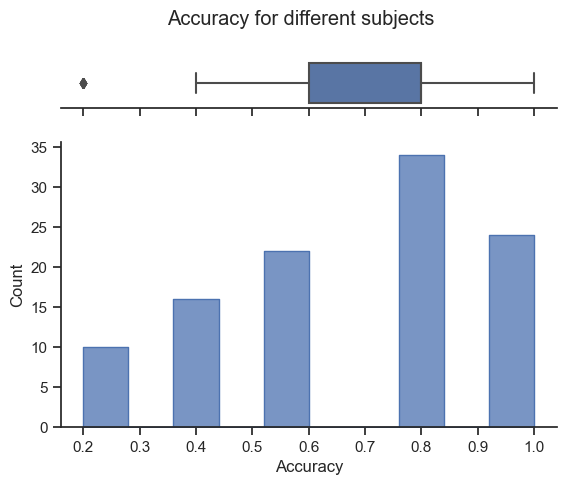

In [ ]:
max_value = [max(csplda, nn) for csplda, nn in zip(acc_results_csplda, acc_results_nn)]
display_descriptive_statistics(max_value)

Next, let's take a look at the CSP obtained from a subject where good results have not been achieved using either LDA or a neural network.

Subject ID: 14   Best accuracy from both models:  0.2


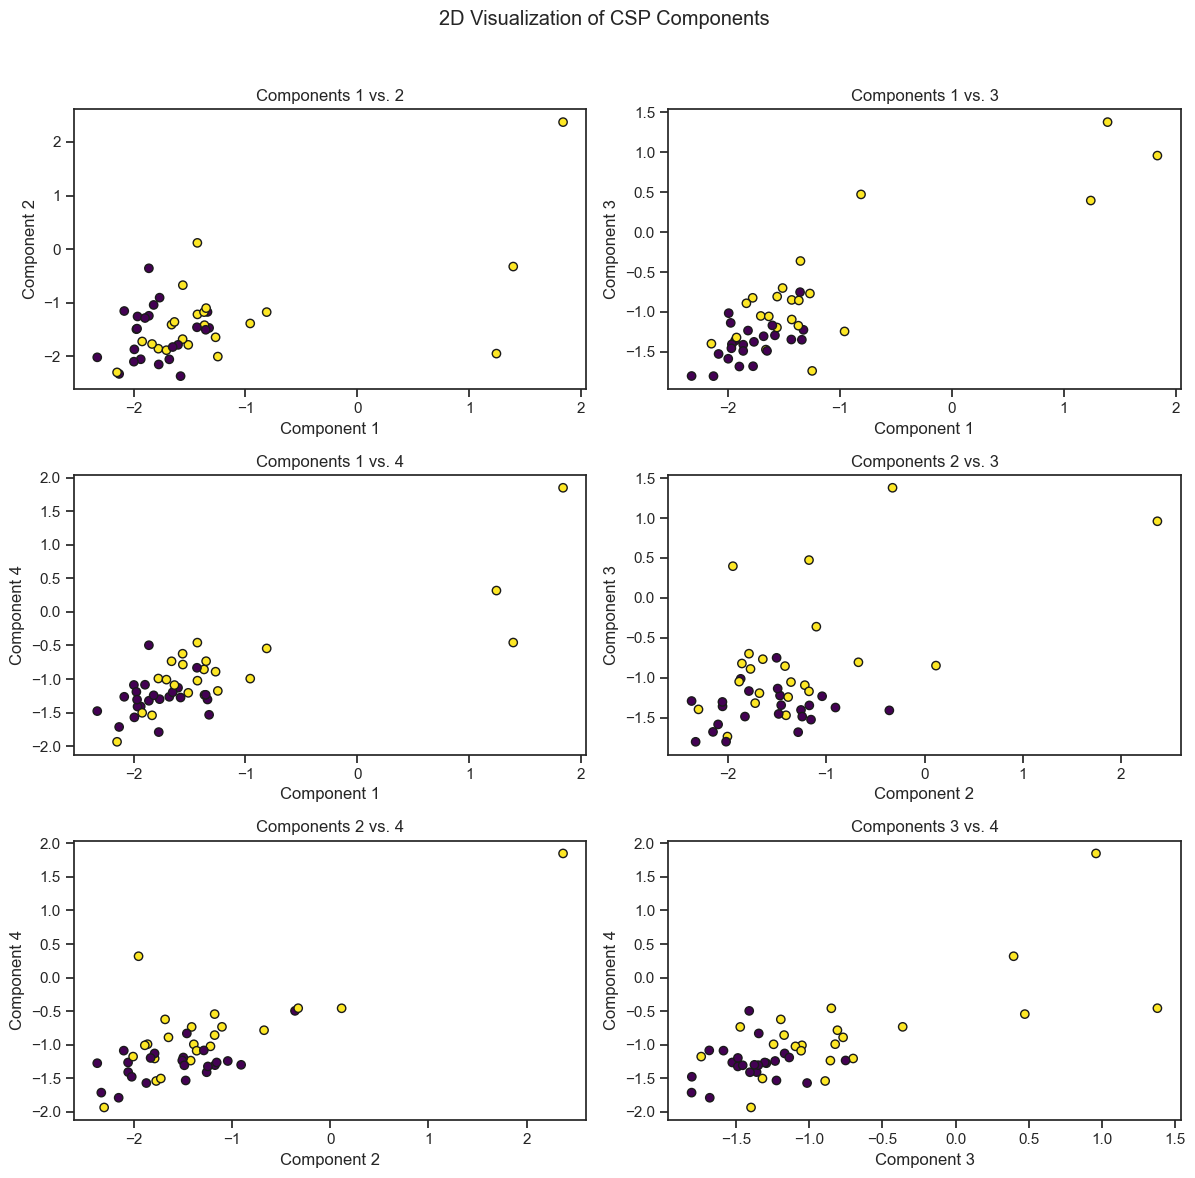

In [ ]:
# vals = index_below_threshold(max_value, threshold=0.2)
vals = [(k + 1, v) for k, v in enumerate(max_value) if v <= 0.2]
id_bad_subject = vals[3][0]
epochs_train, all_labels = extract_motor_imagery_data(id_bad_subject)
all_data = epochs_train.get_data()
print(f'Subject ID: {vals[1][0]}   Best accuracy from both models:  {vals[1][1]}')
visualize_csp_components(all_data, all_labels, num_csp_components=4)


As we can see, the samples obtained from these types of patients are quite challenging to distinguish as they are mixed together. Therefore, our next course of action is to explore the feasibility of using a pre-trained spectral transformer with the entire dataset of subjects and perform fine-tuning on patients where the distance between classes is quite small. The aim is to achieve better predictions than the models previously used.

### Spectral Transformer

For the spectral transformer, we have used the architecture designed in [this paper](https://www.sciencedirect.com/science/article/abs/pii/S1746809423005633) published on June 8, 2023. To have a reference metric for the quality of our spectral transformer, we will compare it with a state-of-the-art transformer in the classification of motor EEG signals. This model is an Attention Temporal Convolutional Network (ATCNet) published in [this paper](https://ieeexplore.ieee.org/document/9852687) on August 9, 2022. The ATCNet model is evaluated using the [BCI Competition IV-2a dataset](https://lampx.tugraz.at/~bci/database/001-2014/description.pdf), which is frequently used to compare neuromotor signal classification models. The dataset is developed by Graz University of Technology in Austria and contains files from 9 different subjects. For each subject, there are 288 training samples and 288 testing samples. The only difference between this dataset and the one initially used is that it classifies 4 classes instead of the original 2.

#### Implementation

The spectral transformer uses the PSD signals as input to the model. Once the signal is transformed, a Positional Encoding is added to it. Then, it passes through a dense layer and is inserted into the encoding block. Finally, it undergoes Global Average Pooling and passes through a classification layer. The structure of the Transformer is detailed in the following image.

<figure>
    <img src="img/st.png" alt="Texto alternativo" style="width:200px; display:block; margin:auto; border:2px dashed #6495ED;" />
    <figcaption style="text-align:center; color:#6495ED; font-style:italic; font-size:18px;">Spectral Transformer</figcaption>
</figure>


For the encoding block, a Pre-LN Transformer is employed. This variation of the transformer arises as a solution to the traditional Post-LN Transformer structure. The latter type of transformer exhibits gradient instability in the Multi-Head Attention layer, necessitating the use of Gradient Warmup during training. As a solution, Pre-LN Transformers change the location of the normalization layer and place it before the Multi-Head Attention layer. The following figure details this explanation:

<figure>
    <img src="img/preln.png" alt="Texto alternativo" style="width:200px; display:block; margin:auto; border:2px dashed #6495ED;" />
    <figcaption style="text-align:center; color:#6495ED; font-style:italic; font-size:18px;">Pre-LN Transformer</figcaption>
</figure>

Let's define the functions that we will use for our **spectral transformer** layer by layer. The **ATCNet** model will be implemented in the *models.py* file. We don't display it in this notebook as it was not part of our main research focus, but rather as a means of comparing our model.

In [25]:
def calculate_psd(data, fs=250):
    """
    Calculates Power Spectral Density (PSD) for each channel in each sample of an EEG dataset.

    Parameters:
    - data (numpy.ndarray): EEG data in the format (n_samples, n_channels, n_samples_per_channel).
    - fs (int): Sampling frequency in Hz.

    Returns:
    - result_data (numpy.ndarray): 3D array containing the calculated PSDs.
    """
    # Calculate the length of the Fourier window
    size_signal = data.shape[2]
    nfft = 2**int(np.ceil(np.log2(size_signal)))

    # Initialize a list to store the PSD results
    result_data = []

    # Iterate over each sample in the dataset
    for i in tqdm(range(data.shape[0])):  
        # Initialize a list to store the PSDs of each channel in the sample
        list_psd = []

        # Iterate over each channel in the sample
        for j in range(data.shape[1]):  
            # Get data from the current channel
            channel_data = data[i, j, :]

            # Calculate the PSD using the welch function from SciPy
            _, psd = welch(channel_data, fs=fs, nperseg=nfft, noverlap=0, nfft=nfft, scaling='density')

            # Add the calculated PSD to the list
            list_psd.append(psd)

        # Add the list of PSDs from the current sample to the results
        result_data.append(list_psd)

    # Convert the results to a numpy array and return them
    return np.array(result_data)

In [52]:
class PreLNEncoder(layers.Layer):
    """
    Implementation of an encoder layer with attention and dense projections for the Spectral Transformer model.

    Parameters:
    - dense_dim (tuple): Dimensions for the dense layers.
    - num_heads (int): Number of heads for multi-head attention.
    - head_size (int): Size of the head for multi-head attention.
    - kernel_regularizer: Kernel regularization for dense layers.
    - kwargs: Additional arguments for the layer.

    """
    def __init__(self, dense_dim, num_heads, head_size, kernel_regularizer, **kwargs):
        super().__init__(**kwargs)
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.head_size = head_size
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=head_size)
        self.dense_proj = Sequential(
            [layers.Dense(dense_dim[0], activation="relu", kernel_regularizer=kernel_regularizer),
             layers.Dense(dense_dim[1], activation="relu", kernel_regularizer=kernel_regularizer),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.add1 = layers.Add()
        self.add2 = layers.Add()

    def call(self, inputs): 
        """
        Call method for the PreLNEncoder layer.

        Parameters:
        - inputs: Input data.

        Returns:
        - output: Layer output.

        """
        # Normalization and attention
        firstNorm_out = self.layernorm_1(inputs)
        attention_output = self.attention(firstNorm_out, firstNorm_out, attention_mask=None)
        
        # Residual connection and more normalization
        add1_out = self.add1([inputs, attention_output])
        secondNorm_out = self.layernorm_2(add1_out)
        
        # Dense projection and another residual connection
        dense_output = self.dense_proj(secondNorm_out)
        output = self.add2([add1_out, dense_output])
        
        return output

    def get_config(self):
        """
        Get the configuration of the PreLNEncoder layer.

        Returns:
        - config: Layer configuration.

        """
        config = super().get_config()
        config.update({
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "head_size": self.head_size,
            "kernel_regularizer": self.kernel_regularizer
        })
        return config

In [27]:
class PositionalEmbedding(layers.Layer):
    """
    Implementation of a positional embedding layer for the Spectral Transformer model.

    Parameters:
    - kwargs: Additional arguments for the layer.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        """
        Build the weights of the layer.

        Parameters:
        - input_shape: Shape of the input data. 
        (batch_size, n_samples_per_channel, n_channels)

        """
        _, sequence_length, embed_dim = input_shape
        self.position_embeddings = self.add_weight(
            shape=(sequence_length, embed_dim),
            initializer="uniform",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs):
        """
        Call method for the PositionalEmbedding layer.

        Parameters:
        - inputs: Input data.

        Returns:
        - output: Layer output.

        """
        positions = tf.range(start=0, limit=tf.shape(inputs)[-2], delta=1)
        embedded_positions = tf.expand_dims(self.position_embeddings, 0)
        return inputs + embedded_positions

    def get_config(self):
        """
        Get the configuration of the PositionalEmbedding layer.

        Returns:
        - config: Layer configuration.

        """
        config = super().get_config()
        return config


In [28]:
class SpectralTransformer(layers.Layer):
    def __init__(self, dense_dim, n_classes, encoder_dense_dims, kernel_regularizer, dropout=0.5, num_heads=8, head_size=128, num_stacked_transformers=4, **kwargs):
        """
        Implementation of a Spectral Transformer model with multiple stacked transformer layers.

        Parameters:
        - dense_dim (tuple): Dimensions for the dense layers.
        - n_channels (int): Number of channels.
        - encoder_dense_dims (tuple): Dimensions for the dense layers of the encoder.
        - kernel_regularizer: Kernel regularization for dense layers.
        - dropout (float): Dropout rate.
        - num_heads (int): Number of heads for multi-head attention.
        - head_size (int): Size of the head for multi-head attention.
        - num_stacked_transformers (int): Number of stacked transformers.
        - kwargs: Additional arguments for the layer.

        """
        super().__init__(**kwargs)
        self.num_stacked_transformers = num_stacked_transformers
        self.positional_embedding = PositionalEmbedding()
        self.dense1 = layers.Dense(dense_dim[0], activation='relu', kernel_regularizer=kernel_regularizer)
        self.dense2 = layers.Dense(dense_dim[1], activation='relu', kernel_regularizer=kernel_regularizer)
        self.dense3 = layers.Dense(n_classes, activation='softmax')
        self.dropout_layers = [layers.Dropout(dropout) for _ in range(num_stacked_transformers)]
        self.preLN_encoders = [PreLNEncoder(dense_dim=encoder_dense_dims, num_heads=num_heads, head_size=head_size, kernel_regularizer=kernel_regularizer) for _ in range(num_stacked_transformers)]
        self.GlobalMaxPooling1D = layers.GlobalMaxPooling1D()

    def call(self, inputs):
        """
        Call method for the SpectralTransformer layer.

        Parameters:
        - inputs: Input data.

        Returns:
        - x: Model output.

        """
        x = self.positional_embedding(inputs)
        x = self.dense1(x)

        # Stacked Transformers
        for i in range(self.num_stacked_transformers):
            x = self.dropout_layers[i](x)
            x = self.preLN_encoders[i](x)

        x = self.GlobalMaxPooling1D(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

    def get_config(self):
        """
        Get the configuration of the SpectralTransformer layer.

        Returns:
        - config: Layer configuration.

        """
        config = super().get_config()
        config.update({
            "dense_dim": self.dense_dim,
            "n_channels": self.n_channels,
            "num_heads": self.num_heads,
            "encoder_dense_dims": self.encoder_dense_dims,
            "kernel_regularizer": self.kernel_regularizer,
            "dropout": self.dropout,
            "head_size": self.head_size,
            "num_stacked_transformers": self.num_stacked_transformers
        })
        return config


We will conduct a test of our model using the BCI competition data. According to the original paper, the number of stacked transformers should be set to 4. However, after a series of experiments, we have found that setting it to 1 yields better results. We omit the experimentation code to make this notebook visually more concise and for code simplicity. In case you want to try different values, feel free to modify the line below.


In [29]:
# Modify if you want to experiment with other values
num_stacked_transformers = 1

Now, let's test the model with the data from subject number 2 in the dataset.


In [35]:
# Define the subject ID and the data path
subject_number = 2
data_path = ""

In [40]:
# Get the training and testing data
X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot = get_BCI_competition_data(data_path, subject_number, isStandard=True)

In [41]:
# Calculate the Power Spectral Density (PSD) for the training and testing data
X_train_psd = np.transpose(calculate_psd(X_train), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test), (0, 2, 1))

100%|██████████| 288/288 [00:02<00:00, 124.23it/s]


In [42]:
# Get the dimensions of the PSD data
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [45]:
# Set up the optimizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.99,
    staircase=True
)

In [46]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',  # You can change to 'val_accuracy' or other metrics
                               patience=1000,  # Number of epochs with no improvement before stopping
                               restore_best_weights=True,  # Restore model weights to the best epoch
                               verbose=1)  # Show detailed messages


In [53]:
# Define the Spectral Transformer model
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam


inputs = Input(shape=(n_samples, n_channels))

# Build the model using the SpectralTransformer class
output = SpectralTransformer(dense_dim=(64, 128),
                             n_classes=4,
                             encoder_dense_dims=(32, 64),
                             kernel_regularizer=regularizers.l1(0.0005),
                             dropout=0.5,
                             num_heads=8,
                             head_size=128,
                             num_stacked_transformers=num_stacked_transformers)(inputs)

# Create the model
SpectralTrans = Model(inputs, output)

# Compile the model
SpectralTrans.compile(optimizer=Adam(learning_rate=lr_schedule),
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])

# Show a summary of the model
SpectralTrans.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1025, 22)]        0         
_________________________________________________________________
spectral_transformer_3 (Spec (None, 4)                 302586    
Total params: 302,586
Trainable params: 302,586
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Train the model
SpectralTrans.fit(X_train_psd,  # Training data
                  y_train_onehot,  # Training labels
                  epochs=500,  # Number of training epochs
                  batch_size=16,  # Batch size
                  validation_data=(X_test_psd, y_test_onehot),
                  callbacks=[early_stopping])  # Validation data


Epoch 1/500
18/18 [==============================] - 6s 252ms/step - loss: 2.3084 - accuracy: 0.2396 - val_loss: 2.3323 - val_accuracy: 0.3125
Epoch 2/500
18/18 [==============================] - 4s 234ms/step - loss: 2.1135 - accuracy: 0.2361 - val_loss: 2.2756 - val_accuracy: 0.2743
Epoch 3/500
18/18 [==============================] - 4s 234ms/step - loss: 2.0864 - accuracy: 0.2847 - val_loss: 2.2584 - val_accuracy: 0.2639
Epoch 4/500
18/18 [==============================] - 4s 234ms/step - loss: 2.0836 - accuracy: 0.2708 - val_loss: 2.2532 - val_accuracy: 0.3368
Epoch 5/500
18/18 [==============================] - 4s 236ms/step - loss: 2.0593 - accuracy: 0.2812 - val_loss: 2.2489 - val_accuracy: 0.3125
Epoch 6/500
18/18 [==============================] - 4s 235ms/step - loss: 2.0498 - accuracy: 0.3472 - val_loss: 2.2445 - val_accuracy: 0.3542
Epoch 7/500
18/18 [==============================] - 4s 238ms/step - loss: 2.0436 - accuracy: 0.3333 - val_loss: 2.2543 - val_accuracy: 0.3264

Accuracy: 0.6006944444444444
Precision: 0.6386897752877134
Recall: 0.6006944444444444
F1 Score: 0.5483618327918607


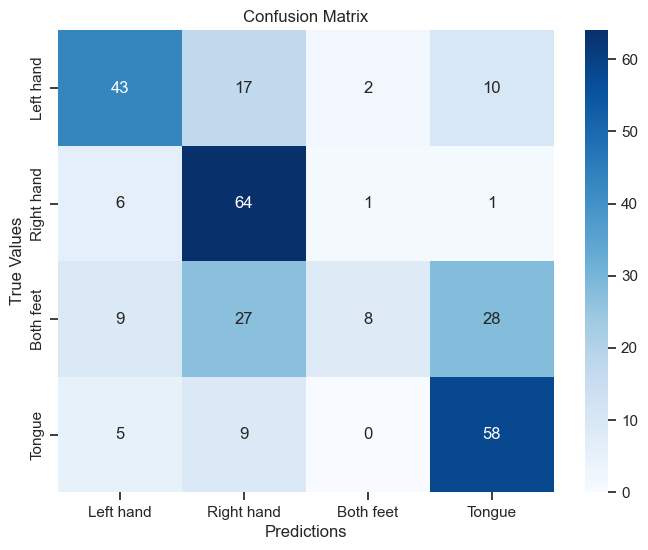

In [59]:
y_pred = SpectralTrans.predict(X_test_psd,batch_size=18)
evaluate_classification_metrics(y_test_onehot, y_pred)